In [1]:
import os
import ot
import json
import pprint
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from utils.preprocessing import feature_normalization
from utils.preprocessing import feature_scaling

plt.style.use('science')

# For figure aesthetics
plt.rcParams['mathtext.fontset'] = 'custom'  
plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'  
plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'  
plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'  
plt.rcParams['font.size'] = 16
plt.rcParams['mathtext.fontset'] = 'stix'  
plt.rcParams['font.family'] = 'STIXGeneral' 

## Baseline Evaluation

### Raw Features

In [2]:
data_mat = np.load('./data/cstr_rawdata.npy')
X = data_mat[:, :-4]
y = df['Class'].values
d = df['Domain'].values

Xs, ys = X[np.where(d == 0)[0]], y[np.where(d == 0)[0]]

clf = SVC(kernel='linear', max_iter=1e+6)

In [3]:
accs = []
for i in range(10):
    Xtr, Xts, ytr, yts = train_test_split(Xs, ys, train_size=0.8, stratify=ys)
    Xtr = feature_normalization(Xtr)
    Xts = feature_normalization(Xts)
    clf.fit(Xtr, ytr)
    yp = clf.predict(Xts)
    accs.append(accuracy_score(yts, yp))
    
print(100 * np.mean(accs), 100 * np.std(accs))

78.57692307692308 0.8779009392702555


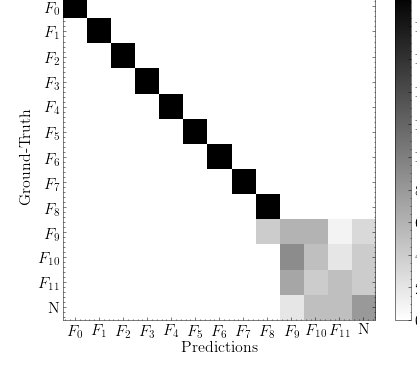

In [4]:
cmat = confusion_matrix(yts, yp)

norm = mpl.colors.Normalize(vmin=0, vmax=20)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap='binary')
cmap.set_array([])

fig, ax = plt.subplots(1, 1, figsize=(7, 6))
ax.imshow(cmat, aspect='auto', cmap='binary')
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax.set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax.set_xticklabels([r"$F_{" + str(int(i)) + "}$" for i in range(12)] + ["N"])
ax.set_yticklabels([r"$F_{" + str(int(i)) + "}$" for i in range(12)] + ["N"])
ax.set_ylabel('Ground-Truth')
ax.set_xlabel('Predictions')

cbar =  fig.colorbar(cmap, ax=ax)
cbar.set_ticks([2 * i for i in range(11)])

plt.savefig('./Figures/Ch6/CMat_Raw.pdf')

### ACF Features

In [5]:
data_mat = np.load('./data/cstr_acfmeandata.npy')
X = data_mat[:, :-4]
y = df['Class'].values
d = df['Domain'].values

Xs, ys = X[np.where(d == 0)[0]], y[np.where(d == 0)[0]]

clf = SVC(kernel='linear', max_iter=1e+6)

In [6]:
accs = []
for i in range(10):
    Xtr, Xts, ytr, yts = train_test_split(Xs, ys, train_size=0.8, stratify=ys)
    Xtr = feature_normalization(Xtr)
    Xts = feature_normalization(Xts)
    clf.fit(Xtr, ytr)
    yp = clf.predict(Xts)
    accs.append(accuracy_score(yts, yp))
    
print(100 * np.mean(accs), 100 * np.std(accs))

99.80769230769229 0.35459786374203284


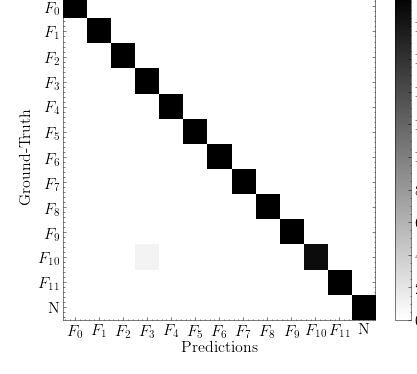

In [7]:
cmat = confusion_matrix(yts, yp)

norm = mpl.colors.Normalize(vmin=0, vmax=20)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap='binary')
cmap.set_array([])

fig, ax = plt.subplots(1, 1, figsize=(7, 6))
ax.imshow(cmat, aspect='auto', cmap='binary')
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax.set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax.set_xticklabels([r"$F_{" + str(int(i)) + "}$" for i in range(12)] + ["N"])
ax.set_yticklabels([r"$F_{" + str(int(i)) + "}$" for i in range(12)] + ["N"])
ax.set_ylabel('Ground-Truth')
ax.set_xlabel('Predictions')

cbar =  fig.colorbar(cmap, ax=ax)
cbar.set_ticks([2 * i for i in range(11)])

plt.savefig('./Figures/Ch6/CMat_ACF.pdf')

### Adaptation Analysis

In [11]:
cmats = []
Gemd = []
Gsink = []
for domain in np.unique(d).astype(int)[1:]:
    Xt = feature_normalization(X[np.where(d == domain)[0]])
    yt = y[np.where(d == domain)[0]]
    
    clf.fit(feature_normalization(Xs), ys)
    yp = clf.predict(Xt)
    cmat = confusion_matrix(yt, yp)
    cmats.append(cmat)
    
    a = ot.unif(Xs.shape[0])
    b = ot.unif(Xt.shape[0])
    M = ot.dist(feature_normalization(Xs), feature_normalization(Xt), metric='cityblock')
    M = M / np.max(M)
    Gemd.append(ot.emd(a, b, M))
    Gsink.append(ot.sinkhorn(a, b, M, reg=1e-3))

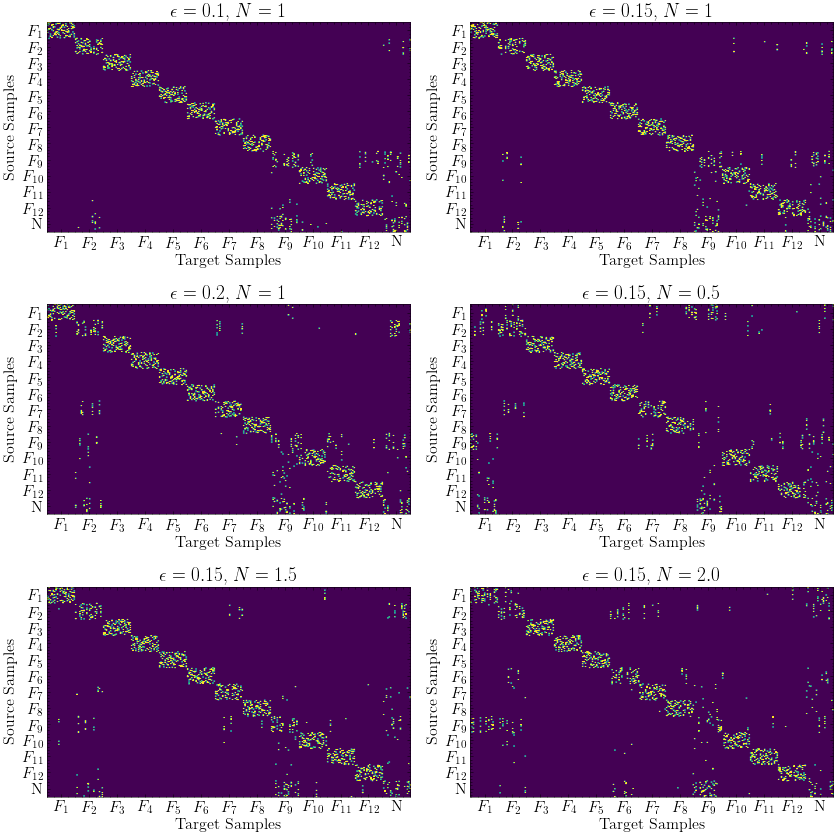

In [35]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
eps = [0.1, 0.15, 0.2, 0.15, 0.15, 0.15]
Ns = [1, 1, 1, 0.5, 1.5, 2.0]
for G, ax, ei, Ni in zip(Gemd, axes.flatten(), eps, Ns):
    ax.imshow(G, cmap='viridis', aspect='auto', vmin=0, vmax=1e-4)
    ax.set_yticks([50 + 100 * i for i in range(13)])
    ax.set_xticks([10 + 20 * i for i in range(13)])
    ax.set_xticklabels([r"$F_{" + str(int(i)) + "}$" for i in range(1, 13)] + ["N"])
    ax.set_yticklabels([r"$F_{" + str(int(i)) + "}$" for i in range(1, 13)] + ["N"])
    ax.set_title(r'$\epsilon = {}$, $N = {}$'.format(ei, Ni))
    ax.set_ylabel('Source Samples')
    ax.set_xlabel('Target Samples')
plt.tight_layout()
plt.savefig('./Figures/Ch6/TransportPlans_EMD.pdf')

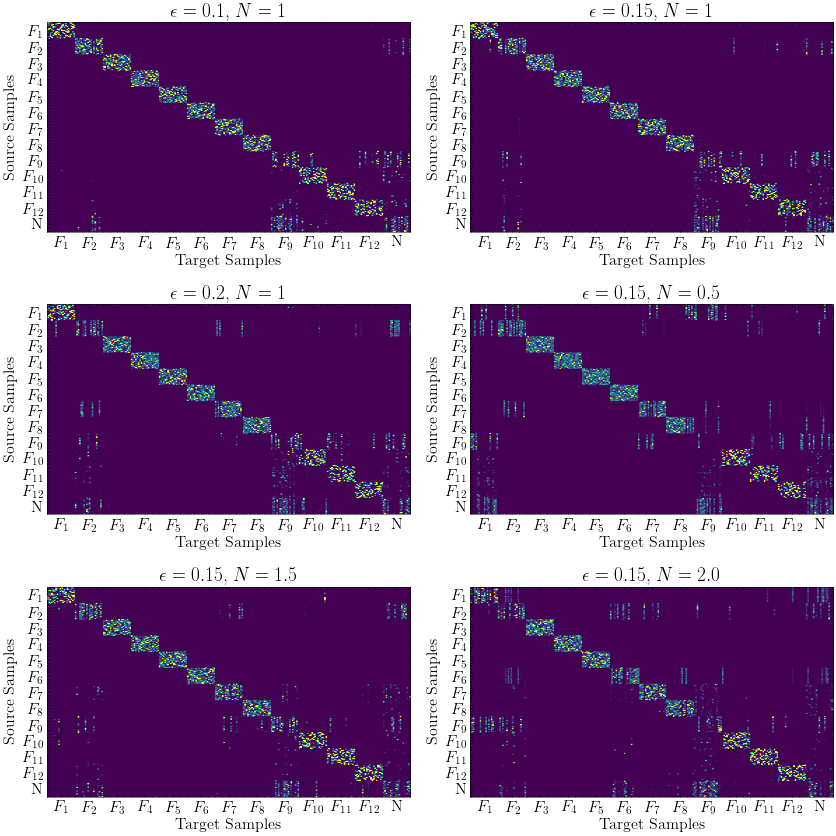

In [36]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
eps = [0.1, 0.15, 0.2, 0.15, 0.15, 0.15]
Ns = [1, 1, 1, 0.5, 1.5, 2.0]
for G, ax, ei, Ni in zip(Gsink, axes.flatten(), eps, Ns):
    ax.imshow(G, cmap='viridis', aspect='auto', vmin=0, vmax=1e-4)
    ax.set_yticks([50 + 100 * i for i in range(13)])
    ax.set_xticks([10 + 20 * i for i in range(13)])
    ax.set_xticklabels([r"$F_{" + str(int(i)) + "}$" for i in range(1, 13)] + ["N"])
    ax.set_yticklabels([r"$F_{" + str(int(i)) + "}$" for i in range(1, 13)] + ["N"])
    ax.set_title(r'$\epsilon = {}$, $N = {}$'.format(ei, Ni))
    ax.set_ylabel('Source Samples')
    ax.set_xlabel('Target Samples')
plt.tight_layout()
plt.savefig('./Figures/Ch6/TransportPlans_Sink.pdf')

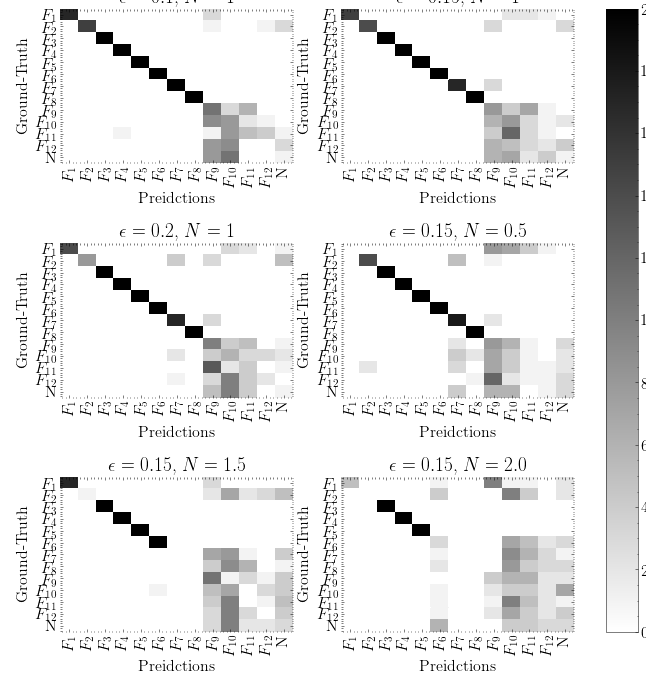

In [15]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
eps = [0.1, 0.15, 0.2, 0.15, 0.15, 0.15]
Ns = [1, 1, 1, 0.5, 1.5, 2.0]
for cmat, ax, ei, Ni in zip(cmats, axes.flatten(), eps, Ns):
    sns.heatmap(cmat, annot=False, ax=ax, cmap='binary', cbar=False,
                xticklabels=[r"$F_{" + str(int(i)) + "}$" for i in range(1, 13)] + ["N"],
                yticklabels=[r"$F_{" + str(int(i)) + "}$" for i in range(1, 13)] + ["N"])
    ax.set_title(r'$\epsilon = {}$, $N = {}$'.format(ei, Ni))
    ax.set_ylabel('Ground-Truth')
    ax.set_xlabel('Preidctions')
plt.tight_layout()
norm = mpl.colors.Normalize(vmin=0, vmax=20)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap='binary')
cmap.set_array([])
cbar =  fig.colorbar(cmap, ax=axes.ravel().tolist())
cbar.set_ticks([2 * i for i in range(11)])

plt.savefig('./Figures/Ch6/RawFeatures_Errs.pdf')

### Transport Plan Comparison

In [16]:
domain = 6
Xt = feature_normalization(X[np.where(d == domain)[0]])
yt = y[np.where(d == domain)[0]]

a = ot.unif(Xs.shape[0])
b = ot.unif(Xt.shape[0])
M = ot.dist(feature_normalization(Xs), feature_normalization(Xt), metric='cityblock')
M = M / np.max(M)

G1 = ot.emd(a, b, M)
G2 = ot.sinkhorn(a, b, M, reg=1e-3)
G3 = ot.da.sinkhorn_lpl1_mm(a, ys, b, M, reg=1e-3, eta=1e-3)
G4 = ot.da.sinkhorn_l1l2_gl(a, ys, b, M, reg=1e-3, eta=1e-3)

/home/eduardo/.local/lib/python3.7/site-packages/ot/optim.py:362: RuntimeWarning: invalid value encountered in log
  return np.sum(M * G) + reg1 * np.sum(G * np.log(G)) + reg2 * f(G)
/home/eduardo/.local/lib/python3.7/site-packages/ot/optim.py:390: RuntimeWarning: divide by zero encountered in log
  dcost = Mi + reg1 * (1 + np.log(G))  # ??
/home/eduardo/.local/lib/python3.7/site-packages/ot/optim.py:68: RuntimeWarning: invalid value encountered in multiply
  derphi0 = np.sum(pk * gfk)  # Quickfix for matrices
/home/eduardo/.local/lib/python3.7/site-packages/ot/optim.py:362: RuntimeWarning: divide by zero encountered in log
  return np.sum(M * G) + reg1 * np.sum(G * np.log(G)) + reg2 * f(G)
/home/eduardo/.local/lib/python3.7/site-packages/ot/optim.py:362: RuntimeWarning: invalid value encountered in multiply
  return np.sum(M * G) + reg1 * np.sum(G * np.log(G)) + reg2 * f(G)


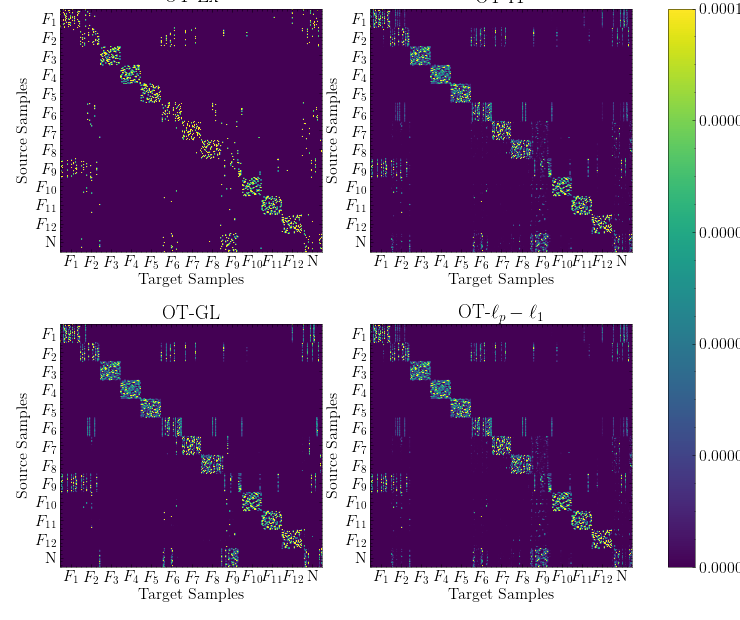

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(11, 9))

norm = mpl.colors.Normalize(vmin=0, vmax=1e-4)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap='viridis')
cmap.set_array([])

ax = axes[0, 0]
ax.imshow(G1, cmap='viridis', aspect='auto', vmin=0, vmax=1e-4)
ax.set_yticks([50 + 100 * i for i in range(13)])
ax.set_xticks([10 + 20 * i for i in range(13)])
ax.set_xticklabels([r"$F_{" + str(int(i)) + "}$" for i in range(1, 13)] + ["N"])
ax.set_yticklabels([r"$F_{" + str(int(i)) + "}$" for i in range(1, 13)] + ["N"])
ax.set_title('OT-Ex')
ax.set_ylabel('Source Samples')
ax.set_xlabel('Target Samples')

ax = axes[0, 1]
ax.imshow(G2, cmap='viridis', aspect='auto', vmin=0, vmax=1e-4)
ax.set_yticks([50 + 100 * i for i in range(13)])
ax.set_xticks([10 + 20 * i for i in range(13)])
ax.set_xticklabels([r"$F_{" + str(int(i)) + "}$" for i in range(1, 13)] + ["N"])
ax.set_yticklabels([r"$F_{" + str(int(i)) + "}$" for i in range(1, 13)] + ["N"])
ax.set_title('OT-IT')
ax.set_ylabel('Source Samples')
ax.set_xlabel('Target Samples')

ax = axes[1, 0]
ax.imshow(G3, cmap='viridis', aspect='auto', vmin=0, vmax=1e-4)
ax.set_yticks([50 + 100 * i for i in range(13)])
ax.set_xticks([10 + 20 * i for i in range(13)])
ax.set_xticklabels([r"$F_{" + str(int(i)) + "}$" for i in range(1, 13)] + ["N"])
ax.set_yticklabels([r"$F_{" + str(int(i)) + "}$" for i in range(1, 13)] + ["N"])
ax.set_title('OT-GL')
ax.set_ylabel('Source Samples')
ax.set_xlabel('Target Samples')

ax = axes[1, 1]
ax.imshow(G4, cmap='viridis', aspect='auto', vmin=0, vmax=1e-4)
ax.set_yticks([50 + 100 * i for i in range(13)])
ax.set_xticks([10 + 20 * i for i in range(13)])
ax.set_xticklabels([r"$F_{" + str(int(i)) + "}$" for i in range(1, 13)] + ["N"])
ax.set_yticklabels([r"$F_{" + str(int(i)) + "}$" for i in range(1, 13)] + ["N"])
ax.set_title(r'OT-$\ell_{p}-\ell_{1}$')
ax.set_ylabel('Source Samples')
ax.set_xlabel('Target Samples')

plt.tight_layout()
cbar =  fig.colorbar(cmap, ax=axes.ravel().tolist())
plt.savefig('./Figures/Ch6/TransportPlans_RawFeatures.pdf')

### ACF Features

In [17]:
data_mat = np.load('./data/cstr_meandata.npy')
X = data_mat[:, :-4]
y = df['Class'].values
d = df['Domain'].values

Xs, ys = X[np.where(d == 0)[0]], y[np.where(d == 0)[0]]
Xs = feature_normalization(Xs)

clf = SVC(kernel='linear', max_iter=1e+6)

In [18]:
cmats = []
for domain in np.unique(d).astype(int)[1:]:
    Xt = feature_normalization(X[np.where(d == domain)[0]])
    yt = y[np.where(d == domain)[0]]
    
    clf.fit(feature_normalization(Xs), ys)
    yp = clf.predict(Xt)
    cmat = confusion_matrix(yt, yp)
    cmats.append(cmat)

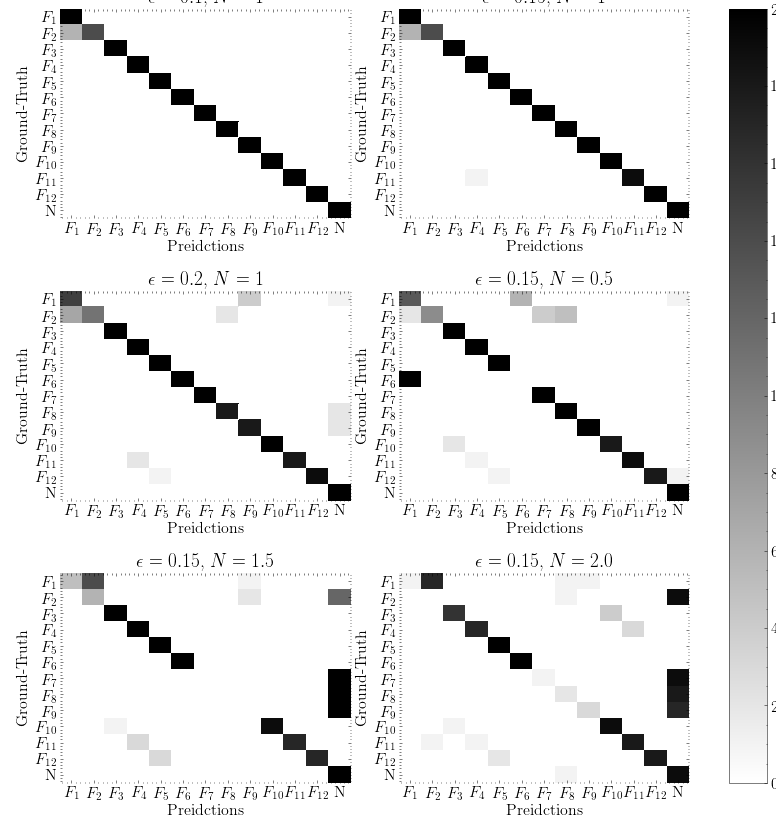

In [19]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
eps = [0.1, 0.15, 0.2, 0.15, 0.15, 0.15]
Ns = [1, 1, 1, 0.5, 1.5, 2.0]
for cmat, ax, ei, Ni in zip(cmats, axes.flatten(), eps, Ns):
    sns.heatmap(cmat, annot=False, ax=ax, cmap='binary', cbar=False,
                xticklabels=[r"$F_{" + str(int(i)) + "}$" for i in range(1, 13)] + ["N"],
                yticklabels=[r"$F_{" + str(int(i)) + "}$" for i in range(1, 13)] + ["N"])
    ax.set_title(r'$\epsilon = {}$, $N = {}$'.format(ei, Ni))
    ax.set_ylabel('Ground-Truth')
    ax.set_xlabel('Preidctions')
plt.tight_layout()

norm = mpl.colors.Normalize(vmin=0, vmax=20)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap='binary')
cmap.set_array([])
cbar =  fig.colorbar(cmap, ax=axes.ravel().tolist())
cbar.set_ticks([2 * i for i in range(11)])
plt.savefig('./Figures/Ch6/ACFFeatures_Errs.pdf')

## Crossvalidation Result Assessment

In [2]:
baseline_accs = [
    np.mean([97.692, 97.308, 92.019, 85.096, 62.981, 59.808]),
    np.mean([68.654, 64.519, 62.404, 59.923, 46.346, 32.981]),
    np.mean([80.192, 75.288, 74.135, 62.500, 69.808, 60.288])
]

baseline_errs = [
    np.std([97.692, 97.308, 92.019, 85.096, 62.981, 59.808]),
    np.std([68.654, 64.519, 62.404, 59.923, 46.346, 32.981]),
    np.std([80.192, 75.288, 74.135, 62.500, 69.808, 60.288])
]

all_names = ['Baseline'] * 3
all_accs = [*baseline_accs]
all_errs = [*baseline_errs]

### Optimal Transport

#### OTDA Comparison

In [3]:
algorithms_for_comparison = [
    'EMD',
    'Sinkhorn',
    'Sinkhorn_l1l2',
    'Sinkhorn_lpl1'
]

proxy_names = [
    'OT-IT',
    'OT-Ex',
    'OT-GL',
    r'OT-$\ell_{p}\ell_{1}$'
]

features_for_comparison = [
    'ACF',
    'Raw',
    'CNN'
]



dictionaries = {}
for features in features_for_comparison:
    files_dir = './results/{}/'.format(features)
    files = os.listdir(files_dir)
    for file in files:
        file_algorithm = file.split('_cval.json')[0]
        if file_algorithm in algorithms_for_comparison:
            with open(os.path.join(files_dir, file), 'r') as f:
                dictionary = json.loads(f.read())
            dictionaries['{},{}'.format(features,
                                        file_algorithm)] = dictionary

In [4]:
best_accs = []
best_errs = []


for algorithm in dictionaries:
    best_acc = - np.inf
    best_err = - np.inf
    dictionary = dictionaries[algorithm]
    for key in dictionary:
        acc, err = dictionary[key]
        if acc > best_acc:
            best_acc = acc
            best_err = err
    print(algorithm, best_acc, best_err)
    best_accs.append(100 * best_acc)
    best_errs.append(100 * best_err)

ACF,Sinkhorn 0.9113782051282051 0.09728250514370429
ACF,EMD 0.9144230769230769 0.07237772794830315
ACF,Sinkhorn_l1l2 0.8868589743589742 0.09128315416360536
ACF,Sinkhorn_lpl1 0.8940705128205128 0.078461021292497
Raw,Sinkhorn 0.7876602564102564 0.06683998826964974
Raw,EMD 0.8653846153846154 0.04054455508136154
Raw,Sinkhorn_l1l2 0.6855769230769232 0.06377882996632792
Raw,Sinkhorn_lpl1 0.8206730769230769 0.05999863883235769
CNN,Sinkhorn 0.8209935897435897 0.03887762381453925
CNN,EMD 0.8338141025641025 0.038330773969101485
CNN,Sinkhorn_l1l2 0.8056089743589744 0.04160776161677904
CNN,Sinkhorn_lpl1 0.8088141025641026 0.04190299105202213


In [5]:
for algorithm in ['ACF,EMD', 'Raw,EMD', 'CNN,EMD']:
    all_names.append('OTDA')
    best_acc = - np.inf
    best_err = - np.inf
    dictionary = dictionaries[algorithm]
    for key in dictionary:
        acc, err = dictionary[key]
        if acc > best_acc:
            best_acc = acc
            best_err = err
    print(algorithm, best_acc, best_err)
    all_accs.append(100 * best_acc)
    all_errs.append(100 * best_err)

ACF,EMD 0.9144230769230769 0.07237772794830315
Raw,EMD 0.8653846153846154 0.04054455508136154
CNN,EMD 0.8338141025641025 0.038330773969101485


In [6]:
all_names

['Baseline', 'Baseline', 'Baseline', 'OTDA', 'OTDA', 'OTDA']

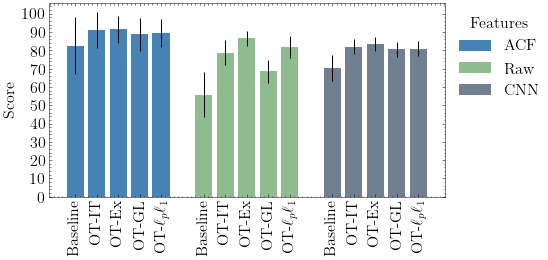

In [23]:
plt.figure(figsize=(8, 4))
plt.bar(np.arange(5),
        [baseline_accs[0]] + best_accs[:4],
        yerr=[baseline_errs[0]] + best_errs[:4],
        label='ACF', color='steelblue')
plt.bar(np.arange(5) + 6,
        [baseline_accs[1]] + best_accs[4:8],
        yerr=[baseline_errs[1]] + best_errs[4:8],
        label='Raw', color='darkseagreen')
plt.bar(np.arange(5) + 12,
        [baseline_accs[2]] + best_accs[8:],
        yerr=[baseline_errs[2]] + best_errs[8:],
        label='CNN', color='slategray')

plt.xticks(ticks=[0, 1, 2, 3, 4,
                  6, 7, 8, 9, 10,
                  12, 13, 14, 15, 16],
           labels=(['Baseline'] + proxy_names) * 3, rotation=90)
plt.yticks(ticks=[10 * i for i in range(11)])
plt.ylabel('Score')

plt.legend(title='Features', bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.savefig('./Figures/Ch6/OTDA_Comparison.pdf')

#### Global Comparison

In [7]:
algorithms_for_comparison = [
    'MP',
    'JDOT',
    'EMD'
]

proxy_names = [
    'MP',
    'JDOT',
    'OTDA'
]

features_for_comparison = [
    'ACF',
    'Raw',
    'CNN'
]



dictionaries = {}
for features in features_for_comparison:
    files_dir = './results/{}/'.format(features)
    files = os.listdir(files_dir)
    for file in files:
        file_algorithm = file.split('_cval.json')[0]
        if file_algorithm in algorithms_for_comparison:
            with open(os.path.join(files_dir, file), 'r') as f:
                dictionary = json.loads(f.read())
            dictionaries['{},{}'.format(features,
                                        file_algorithm)] = dictionary

In [8]:
best_accs = []
best_errs = []
for algorithm in dictionaries:
    best_acc = - np.inf
    best_err = - np.inf
    dictionary = dictionaries[algorithm]
    for key in dictionary:
        acc, err = dictionary[key]
        if acc > best_acc:
            best_acc = acc
            best_err = err
    print(algorithm, best_acc, best_err)
    best_accs.append(100 * best_acc)
    best_errs.append(100 * best_err)

ACF,MP 0.896474358974359 0.08141467280570802
ACF,JDOT 0.8714743589743589 0.11761685126508092
ACF,EMD 0.9144230769230769 0.07237772794830315
Raw,MP 0.8368589743589744 0.05091212731196091
Raw,JDOT 0.7886217948717951 0.05650055600373417
Raw,EMD 0.8653846153846154 0.04054455508136154
CNN,MP 0.8209935897435897 0.05156696693838217
CNN,JDOT 0.8116987179487177 0.06576392772392665
CNN,EMD 0.8338141025641025 0.038330773969101485


In [9]:
for algorithm in ['ACF,MP', 'Raw,MP', 'CNN,MP']:
    all_names.append('MP')
    best_acc = - np.inf
    best_err = - np.inf
    dictionary = dictionaries[algorithm]
    for key in dictionary:
        acc, err = dictionary[key]
        if acc > best_acc:
            best_acc = acc
            best_err = err
    print(algorithm, best_acc, best_err)
    all_accs.append(100 * best_acc)
    all_errs.append(100 * best_err)
    
for algorithm in ['ACF,JDOT', 'Raw,JDOT', 'CNN,JDOT']:
    all_names.append('JDOT')
    best_acc = - np.inf
    best_err = - np.inf
    dictionary = dictionaries[algorithm]
    for key in dictionary:
        acc, err = dictionary[key]
        if acc > best_acc:
            best_acc = acc
            best_err = err
    print(algorithm, best_acc, best_err)
    all_accs.append(100 * best_acc)
    all_errs.append(100 * best_err)

ACF,MP 0.896474358974359 0.08141467280570802
Raw,MP 0.8368589743589744 0.05091212731196091
CNN,MP 0.8209935897435897 0.05156696693838217
ACF,JDOT 0.8714743589743589 0.11761685126508092
Raw,JDOT 0.7886217948717951 0.05650055600373417
CNN,JDOT 0.8116987179487177 0.06576392772392665


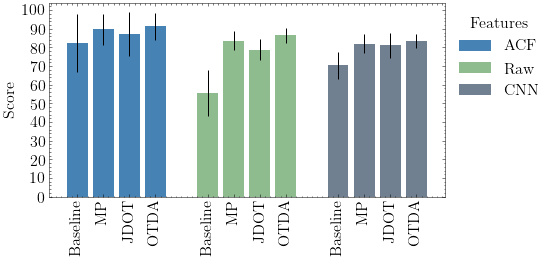

In [119]:
plt.figure(figsize=(8, 4))
plt.bar(np.arange(4),
        [baseline_accs[0]] + best_accs[:3],
        yerr=[baseline_errs[0]] + best_errs[:3],
        label='ACF', color='steelblue')
plt.bar(np.arange(4) + 5,
        [baseline_accs[1]] + best_accs[3:6],
        yerr=[baseline_errs[1]] + best_errs[3:6],
        label='Raw', color='darkseagreen')
plt.bar(np.arange(4) + 10,
        [baseline_accs[2]] + best_accs[6:],
        yerr=[baseline_errs[2]] + best_errs[6:],
        label='CNN', color='slategray')

plt.xticks(ticks=[0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 13],
           labels=(['Baseline'] + proxy_names) * 3, rotation=90)
plt.yticks(ticks=[10 * i for i in range(11)])
plt.ylabel('Score')

plt.legend(title='Features', bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.savefig('./Figures/Ch6/DABased_Comparison.pdf')

### Instance Based

In [10]:
algorithms_for_comparison = [
    'KMM',
    'KLIEP',
    'uLSIF'
]

features_for_comparison = [
    'ACF',
    'Raw',
    'CNN'
]



dictionaries = {}
for features in features_for_comparison:
    files_dir = './results/{}/'.format(features)
    files = os.listdir(files_dir)
    for file in files:
        file_algorithm = file.split('_cval.json')[0]
        if file_algorithm in algorithms_for_comparison:
            with open(os.path.join(files_dir, file), 'r') as f:
                dictionary = json.loads(f.read())
            dictionaries['{},{}'.format(features,
                                        file_algorithm)] = dictionary

In [11]:
best_accs = []
best_errs = []
for algorithm in dictionaries:
    best_acc = - np.inf
    best_err = - np.inf
    dictionary = dictionaries[algorithm]
    for key in dictionary:
        acc, err = dictionary[key]
        if acc > best_acc:
            best_acc = acc
            best_err = err
    print(algorithm, best_acc, best_err)
    best_accs.append(100 * best_acc)
    best_errs.append(100 * best_err)

ACF,KMM 0.8312499999999999 0.14116806983111377
ACF,uLSIF 0.8306089743589743 0.14169829746079277
ACF,KLIEP 0.8248397435897435 0.15510047233033822
Raw,KMM 0.5596153846153846 0.12595419825941329
Raw,uLSIF 0.5573717948717948 0.12086053560366047
Raw,KLIEP 0.5532051282051281 0.12229149761084249
CNN,KMM 0.5812499999999999 0.1333187900414136
CNN,uLSIF 0.6065705128205128 0.11949853187652269
CNN,KLIEP 0.6134615384615384 0.11187504476435145


In [12]:
for algorithm in ['ACF,KMM', 'Raw,KMM', 'CNN,KMM']:
    all_names.append('KMM')
    best_acc = - np.inf
    best_err = - np.inf
    dictionary = dictionaries[algorithm]
    for key in dictionary:
        acc, err = dictionary[key]
        if acc > best_acc:
            best_acc = acc
            best_err = err
    print(algorithm, best_acc, best_err)
    all_accs.append(100 * best_acc)
    all_errs.append(100 * best_err)
    
for algorithm in ['ACF,uLSIF', 'Raw,uLSIF', 'CNN,uLSIF']:
    all_names.append('uLSIF')
    best_acc = - np.inf
    best_err = - np.inf
    dictionary = dictionaries[algorithm]
    for key in dictionary:
        acc, err = dictionary[key]
        if acc > best_acc:
            best_acc = acc
            best_err = err
    print(algorithm, best_acc, best_err)
    all_accs.append(100 * best_acc)
    all_errs.append(100 * best_err)
    
for algorithm in ['ACF,KLIEP', 'Raw,KLIEP', 'CNN,KLIEP']:
    all_names.append('KLIEP')
    best_acc = - np.inf
    best_err = - np.inf
    dictionary = dictionaries[algorithm]
    for key in dictionary:
        acc, err = dictionary[key]
        if acc > best_acc:
            best_acc = acc
            best_err = err
    print(algorithm, best_acc, best_err)
    all_accs.append(100 * best_acc)
    all_errs.append(100 * best_err)

ACF,KMM 0.8312499999999999 0.14116806983111377
Raw,KMM 0.5596153846153846 0.12595419825941329
CNN,KMM 0.5812499999999999 0.1333187900414136
ACF,uLSIF 0.8306089743589743 0.14169829746079277
Raw,uLSIF 0.5573717948717948 0.12086053560366047
CNN,uLSIF 0.6065705128205128 0.11949853187652269
ACF,KLIEP 0.8248397435897435 0.15510047233033822
Raw,KLIEP 0.5532051282051281 0.12229149761084249
CNN,KLIEP 0.6134615384615384 0.11187504476435145


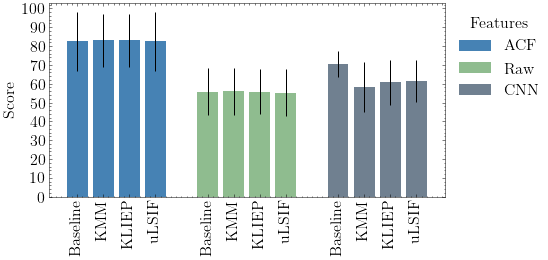

In [81]:
plt.figure(figsize=(8, 4))
plt.bar(np.arange(4),
        [baseline_accs[0]] + best_accs[:3],
        yerr=[baseline_errs[0]] + best_errs[:3],
        label='ACF', color='steelblue')
plt.bar(np.arange(4) + 5,
        [baseline_accs[1]] + best_accs[3:6],
        yerr=[baseline_errs[1]] + best_errs[3:6],
        label='Raw', color='darkseagreen')
plt.bar(np.arange(4) + 10,
        [baseline_accs[2]] + best_accs[6:],
        yerr=[baseline_errs[2]] + best_errs[6:],
        label='CNN', color='slategray')

plt.xticks(ticks=[0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 13],
           labels=(['Baseline'] + algorithms_for_comparison) * 3, rotation=90)
plt.yticks(ticks=[10 * i for i in range(11)])
plt.ylabel('Score')

plt.legend(title='Features', bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.savefig('./Figures/Ch6/Instance_Comparison.pdf')

### Feature Based

In [13]:
algorithms_for_comparison = [
    'PCA',
    'TCA',
    'GFK'
]

features_for_comparison = [
    'ACF',
    'Raw',
    'CNN'
]



dictionaries = {}
for features in features_for_comparison:
    files_dir = './results/{}/'.format(features)
    files = os.listdir(files_dir)
    for file in files:
        file_algorithm = file.split('_cval.json')[0]
        if file_algorithm in algorithms_for_comparison:
            with open(os.path.join(files_dir, file), 'r') as f:
                dictionary = json.loads(f.read())
            dictionaries['{},{}'.format(features,
                                        file_algorithm)] = dictionary

In [14]:
pca_ndims = np.array(list(dictionaries['CNN,PCA'].keys())).astype(int)[:-3]
pca_scores = np.array([dictionaries['CNN,PCA'][ndim][0] for ndim in dictionaries['CNN,PCA']][:-3])

In [15]:
gfk_ndims = np.array([key.split(',')[0] for key in list(dictionaries['CNN,GFK'].keys())[::2]]).astype(int)[:-2]
gfk_scores_pca = np.array([dictionaries['CNN,GFK'][ndim][0] for ndim in dictionaries['CNN,GFK']])[::2][:-2]
gfk_scores_pls = np.array([dictionaries['CNN,GFK'][ndim][0] for ndim in dictionaries['CNN,GFK']])[1::2][:-2]

In [16]:
tca_scores = []
tca_ndims = [2, 10, 15, 20, 25, 30]
for ndim in tca_ndims:
    tmp_scores = [
        dictionaries['CNN,TCA'][key][0] for key in dictionaries['CNN,TCA'] if str(ndim) == key.split(',')[0]
    ]
    tca_scores.append(np.max(tmp_scores))
tca_scores = np.array(tca_scores)

Text(0, 0.5, 'Score')

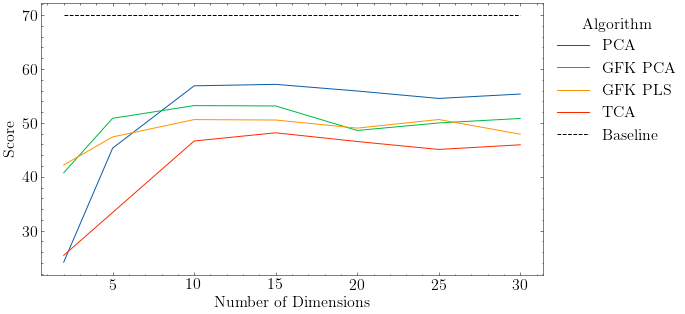

In [86]:
plt.figure(figsize=(9, 5))

plt.plot(pca_ndims, 100 * pca_scores, label='PCA')
plt.plot(gfk_ndims, 100 * gfk_scores_pca, label='GFK PCA')
plt.plot(gfk_ndims, 100 * gfk_scores_pls, label='GFK PLS')
plt.plot(tca_ndims, 100 * tca_scores, label='TCA')
plt.plot(pca_ndims, [70.000] * len(pca_ndims), label='Baseline', c='k', linestyle='--')
plt.legend(title='Algorithm', bbox_to_anchor=(1, 1))
plt.xlabel('Number of Dimensions')
plt.ylabel('Score')

In [17]:
best_accs = []
best_errs = []
for algorithm in dictionaries:
    best_acc = - np.inf
    best_err = - np.inf
    best_key = None
    dictionary = dictionaries[algorithm]
    for key in dictionary:
        acc, err = dictionary[key]
        if acc > best_acc:
            best_acc = acc
            best_err = err
            best_key = key
    print(algorithm, best_acc, best_err, best_key)
    best_accs.append(100 * best_acc)
    best_errs.append(100 * best_err)

ACF,GFK 0.7791666666666668 0.032215923288747804 5,pca
ACF,TCA 0.8107371794871794 0.1513300017717114 13,rbf,10.0,None
ACF,PCA 0.8251602564102564 0.15176214360989487 10
Raw,GFK 0.5480769230769231 0.07910175892039192 100,pca
Raw,TCA 0.6246794871794872 0.13706636241418585 300,rbf,10.0,None
Raw,PCA 0.5644230769230769 0.11651026780902599 25
CNN,GFK 0.532051282051282 0.12866743569074535 10,pca
CNN,TCA 0.4815705128205128 0.07533500269789895 15,100.0,None
CNN,PCA 0.5785256410256411 0.14383456978357384 300


In [18]:
for algorithm in ['ACF,GFK', 'Raw,GFK', 'CNN,GFK']:
    all_names.append('GFK')
    best_acc = - np.inf
    best_err = - np.inf
    dictionary = dictionaries[algorithm]
    for key in dictionary:
        acc, err = dictionary[key]
        if acc > best_acc:
            best_acc = acc
            best_err = err
    print(algorithm, best_acc, best_err)
    all_accs.append(100 * best_acc)
    all_errs.append(100 * best_err)
    
for algorithm in ['ACF,TCA', 'Raw,TCA', 'CNN,TCA']:
    all_names.append('TCA')
    best_acc = - np.inf
    best_err = - np.inf
    dictionary = dictionaries[algorithm]
    for key in dictionary:
        acc, err = dictionary[key]
        if acc > best_acc:
            best_acc = acc
            best_err = err
    print(algorithm, best_acc, best_err)
    all_accs.append(100 * best_acc)
    all_errs.append(100 * best_err)
    
for algorithm in ['ACF,PCA', 'Raw,PCA', 'CNN,PCA']:
    all_names.append('PCA')
    best_acc = - np.inf
    best_err = - np.inf
    dictionary = dictionaries[algorithm]
    for key in dictionary:
        acc, err = dictionary[key]
        if acc > best_acc:
            best_acc = acc
            best_err = err
    print(algorithm, best_acc, best_err)
    all_accs.append(100 * best_acc)
    all_errs.append(100 * best_err)

ACF,GFK 0.7791666666666668 0.032215923288747804
Raw,GFK 0.5480769230769231 0.07910175892039192
CNN,GFK 0.532051282051282 0.12866743569074535
ACF,TCA 0.8107371794871794 0.1513300017717114
Raw,TCA 0.6246794871794872 0.13706636241418585
CNN,TCA 0.4815705128205128 0.07533500269789895
ACF,PCA 0.8251602564102564 0.15176214360989487
Raw,PCA 0.5644230769230769 0.11651026780902599
CNN,PCA 0.5785256410256411 0.14383456978357384


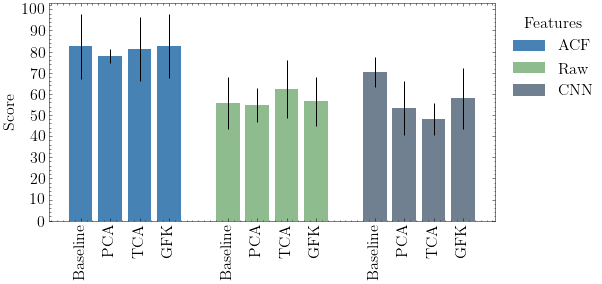

In [90]:
plt.figure(figsize=(8, 4))
plt.bar(np.arange(4),
        [baseline_accs[0]] + best_accs[:3],
        yerr=[baseline_errs[0]] + best_errs[:3],
        label='ACF', color='steelblue')
plt.bar(np.arange(4) + 5,
        [baseline_accs[1]] + best_accs[3:6],
        yerr=[baseline_errs[1]] + best_errs[3:6],
        label='Raw', color='darkseagreen')
plt.bar(np.arange(4) + 10,
        [baseline_accs[2]] + best_accs[6:],
        yerr=[baseline_errs[2]] + best_errs[6:],
        label='CNN', color='slategray')

plt.xticks(ticks=[0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 13],
           labels=(['Baseline'] + algorithms_for_comparison) * 3, rotation=90)
plt.yticks(ticks=[10 * i for i in range(11)])
plt.ylabel('Score')

plt.legend(title='Features', bbox_to_anchor=(1.25, 1))
# plt.tight_layout()
plt.savefig('./Figures/Ch6/Feature_Comparison.pdf')

## Complete Results

In [19]:
acf_results = [
    all_names[::3], all_accs[::3], all_errs[::3]
]

raw_results = [
    all_names[1::3], all_accs[1::3], all_errs[1::3]
]

cnn_results = [
    all_names[2::3], all_accs[2::3], all_errs[2::3]
]

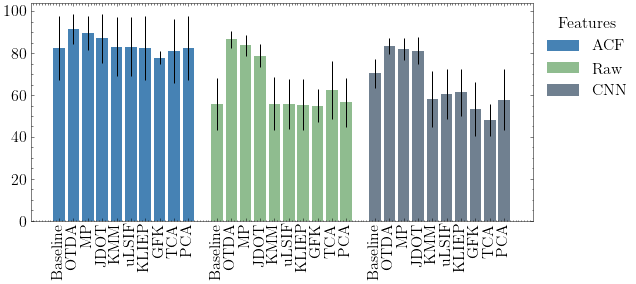

In [21]:
plt.figure(figsize=(9, 4))

offset = 0
plt.bar(np.arange(len(acf_results[1])) + offset, acf_results[1], yerr=acf_results[2], label='ACF',
        color='steelblue')
offset += len(acf_results[1])
plt.bar(np.arange(len(raw_results[1])) + 1 + offset, raw_results[1], yerr=raw_results[2], label='Raw',
        color='darkseagreen')
offset += len(raw_results[1])
plt.bar(np.arange(len(cnn_results[1])) + 2 + offset, cnn_results[1], yerr=cnn_results[2], label='CNN',
        color='slategray')

ticks_locations = np.hstack([
    np.arange(len(acf_results[1])),
    np.arange(len(raw_results[1])) + 1 + len(acf_results[1]),
    np.arange(len(cnn_results[1])) + 2 + len(acf_results[1]) + len(acf_results[1])
])

_ = plt.xticks(ticks_locations, labels=acf_results[0] + raw_results[0] + cnn_results[0], rotation=90)
plt.legend(title='Features', bbox_to_anchor=(1, 1))
plt.savefig('./Figures/Ch6/CompleteComparison.pdf')